In [3]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install trimesh
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import scipy.io
import logging
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import torchvision.transforms as transforms
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from torchvision.utils import make_grid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 11.5 MB/s eta 0:00:00 0:00:01


In [8]:
# masks.classes

['bed',
 'bookcase',
 'chair',
 'desk',
 'misc',
 'sofa',
 'table',
 'tool',
 'wardrobe']

# 3D-Pix2Pix 1st trial

In [2]:
logging.basicConfig(level=logging.INFO)

class Pix3DJSONDataset(Dataset):
    def __init__(self, base_dir, json_file, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.data = self.load_json(json_file)

    def load_json(self, json_file):
        with open(json_file, 'r') as f:
            data = json.load(f)
        logging.info(f"Loaded {len(data)} samples from JSON file")
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Load image
        img_path = os.path.join(self.base_dir, item['img'])
        image = self.load_image(img_path)
        
        # Load 3D model (as voxel)
        voxel_path = os.path.join(self.base_dir, item['voxel'])
        voxel = self.load_voxel(voxel_path)
        
        # Get category
        category = item['category']
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        voxel = torch.from_numpy(voxel).float()

        return image, voxel, category

    def load_image(self, path):
        try:
            with Image.open(path) as img:
                return img.convert('RGB')
        except Exception as e:
            logging.error(f"Error loading image {path}: {str(e)}")
            raise

    def load_voxel(self, path):
        try:
            voxel_data = scipy.io.loadmat(path)
            voxel = voxel_data['voxel'].astype(np.float32)
            return voxel
        except Exception as e:
            logging.error(f"Error loading voxel {path}: {str(e)}")
            raise



In [3]:
# Define transforms
transform = transforms.Compose([
#         transforms.Grayscale(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
base_dir = '/kaggle/input/pix3d-dataset'
json_file = '/kaggle/input/pix3d-dataset/pix3d.json'  # Adjust this path as needed
dataset = Pix3DJSONDataset(base_dir, json_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

In [12]:
# Print some information about the dataset
print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

# Try to get the first batch
first_batch = next(iter(dataloader))
print(f"First batch shapes:")
print(f"  Images: {first_batch[0].shape}")
print(f"  Voxels: {first_batch[1].shape}")
print(f"First batch categories: {first_batch[2]}")


Dataset size: 10069
Number of batches: 10069
First batch shapes:
  Images: torch.Size([1, 3, 128, 128])
  Voxels: torch.Size([1, 128, 128, 128])
First batch categories: ('chair',)


In [5]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [6]:
def downsample_volume(volume, scale_factor=0.5):
    downsampled = F.interpolate(volume, scale_factor=scale_factor, mode='nearest')
    return downsampled.squeeze()

In [7]:
# Matplotlib visualization (faster, simplified)
def get_volume_views(volume, downsample=True, scale_factor=0.5):
    if downsample:
        volume = downsample_volume(volume, scale_factor)
    volume = volume.squeeze().detach().numpy()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(volume, edgecolor='k')  # No edges for faster rendering
    
    # Save or display
    plt.show()
    plt.close()


In [8]:
for batch in dataloader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([1, 3, 128, 128])
torch.Size([1, 128, 128, 128])


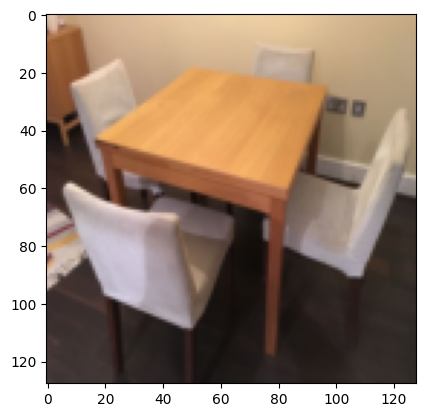

In [12]:
show_tensor_images(batch[0][0])

In [30]:
batch[1][0].shape

torch.Size([128, 128, 128])

In [ ]:
get_volume_views(batch[1][0], downsample=True, scale_factor=0.25)

# Generator

In [9]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',drop=False,norm=True):
        super().__init__()
        self.drop=drop
        self.norm=norm
        self.dropout=nn.Dropout(0.5)
        if self.norm==True:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose3d(in_channels,out_channels,4,2,1),
                nn.BatchNorm2d(out_channels) if down else nn.BatchNorm3d(out_channels),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
        else:
            self.block=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose3d(in_channels,out_channels,4,2,1),
                nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
            )
            
    def forward(self,x):
        x=self.block(x)
        return self.dropout(x) if self.drop else x

In [10]:
class Generator(nn.Module):
    def __init__(self,hidden_dim=32,in_channels=3):
        super(Generator,self).__init__() 
        self.down1=Block(in_channels,hidden_dim,down=True,act='leaky',drop=False)
        self.down2=Block(hidden_dim,hidden_dim*2,down=True,act='leaky',drop=False)
        self.down3=Block(hidden_dim*2,hidden_dim*4,down=True,act='leaky',drop=False)        
        self.down4=Block(hidden_dim*4,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down5=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)
        self.down6=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)
        self.down7=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False,norm=False)
 
        self.bottleneck=nn.Sequential(
            nn.Conv3d(hidden_dim*8,hidden_dim*8,3,2,1),
            nn.ReLU()
        )
        
        self.up1=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up2=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up3=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)
        self.up4=Block(hidden_dim*8*2,hidden_dim*4,down=False,act='relu',drop=True)
        self.up5=Block(hidden_dim*4*2,hidden_dim*2,down=False,act='relu',drop=True)
        self.up6=Block(hidden_dim*2*2,hidden_dim,down=False,act='relu',drop=True)
        self.up7=Block(hidden_dim*2,1,down=False,act='relu',drop=True)
        
        self.final_up=nn.Sequential(
            nn.ConvTranspose3d(hidden_dim*2,in_channels,4,2,1),
            nn.Tanh()
        )
        
    def forward(self,x):
        d1=self.down1(x)
#         print("down1: ",d1.shape) #[BATCH_SIZE,32,64,64]
        d2=self.down2(d1)
#         print("down2: ",d2.shape) #[BATCH_SIZE,64,32,32]
        d3=self.down3(d2)
#         print("down3: ",d3.shape) #[BATCH_SIZE,128,16,16]
        d4=self.down4(d3)
#         print("down4: ",d4.shape) #[BATCH_SIZE,256,8,8]
        d5=self.down5(d4)
#         print("down5: ",d5.shape) #[BATCH_SIZE,256,4,4]
        d6=self.down6(d5)
#         print("down6: ",d6.shape) #[BATCH_SIZE,256,2,2]
        d7=self.down7(d6)
#         print("down7: ",d7.shape) #[BATCH_SIZE,256,1,1]
        

        d7_resh=d7.view(-1,256,1,1,1)
#         print("down7 reshaped: ",d7_resh.shape) #[BATCH_SIZE,256,1,1,1]
#         print("="*50)

        bottleneck=self.bottleneck(d7_resh)
#         print("bottleneck: ",bottleneck.shape) #[BATCH_SIZE, 256, 1, 1, 1]
        
#         print("="*50)
        
        up1=self.up1(torch.cat([bottleneck,d7_resh],dim=1))
#         print("up1: ",up1.shape) #[BATCH_SIZE, 256, 2, 2, 2]
        
        d6_resh=d6.view(-1,256,2,2,1).repeat(1,1,1,1,2)
        up2=self.up2(torch.cat([up1,d6_resh],dim=1))
#         print("up2: ",up2.shape) #[BATCH_SIZE, 256, 4, 4, 4]
        d5_resh=d5.view(-1,256,4,4,1).repeat(1,1,1,1,4)
        up3=self.up3(torch.cat([up2,d5_resh],dim=1))
#         print("up3: ",up3.shape) #[BATCH_SIZE, 256, 8, 8, 8]
        d4_resh=d4.view(-1,256,8,8,1).repeat(1,1,1,1,8)
        up4=self.up4(torch.cat([up3,d4_resh],dim=1))
#         print("up4: ",up4.shape) #[BATCH_SIZE, 128, 16, 16, 16]
        d3_resh=d3.view(-1,128,16,16,1).repeat(1,1,1,1,16)
        up5=self.up5(torch.cat([up4,d3_resh],dim=1))
#         print("up5: ",up5.shape) #[BATCH_SIZE, 64, 32, 32, 32]
        d2_resh=d2.view(-1,64,32,32,1).repeat(1,1,1,1,32)
        up6=self.up6(torch.cat([up5,d2_resh],dim=1))
#         print("up6: ",up6.shape) #[BATCH_SIZE, 32, 64, 64,64]
        d1_resh=d1.view(-1,32,64,64,1).repeat(1,1,1,1,64)
        up7=self.up7(torch.cat([up6,d1_resh],dim=1))
#         print("up7: ",up7.shape) #[BATCH_SIZE, 1, 128,128, 128]
        
        return up7.squeeze(0)
#         return up7

In [11]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',drop=False):
        super().__init__()
        self.drop=drop
        self.dropout=nn.Dropout(0.5)
        self.block=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,2,1) if down else nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )
        
    def forward(self,x):
        x=self.block(x)
        return self.dropout(x) if self.drop else x

In [12]:
class Generator(nn.Module):
    def __init__(self,in_channels=3,hidden_dim=64):
        super().__init__()
        self.init_down=nn.Sequential(
            nn.Conv2d(in_channels,hidden_dim,4,2,1),
            nn.LeakyReLU(0.2),
        )
        self.down1=Block(hidden_dim,hidden_dim*2,down=True,act='leaky',drop=False)
        self.down2=Block(hidden_dim*2,hidden_dim*4,down=True,act='leaky',drop=False)        
        self.down3=Block(hidden_dim*4,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down4=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down5=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False)        
        self.down6=Block(hidden_dim*8,hidden_dim*8,down=True,act='leaky',drop=False) 
        
        self.bottleneck=nn.Sequential(
            nn.Conv2d(hidden_dim*8,hidden_dim*8,4,2,1),
            nn.ReLU()
        )
        
        self.up1=Block(hidden_dim*8,hidden_dim*8,down=False,act='relu',drop=True)
        self.up2=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)        
        self.up3=Block(hidden_dim*8*2,hidden_dim*8,down=False,act='relu',drop=True)        
        self.up4=Block(hidden_dim*8*2,hidden_dim*4,down=False,act='relu',drop=True)        
        self.up5=Block(hidden_dim*4*2,hidden_dim*2,down=False,act='relu',drop=True)        
        self.up6=Block(hidden_dim*2*2,hidden_dim,down=False,act='relu',drop=True)        
        self.up7=Block(hidden_dim*2,hidden_dim,down=False,act='relu',drop=True)
        
        self.final_up=nn.Sequential(
            nn.ConvTranspose2d(hidden_dim*2,128,4,2,1),
            nn.Tanh()
        )
#         self.final_layer=nn.Se
        
    def forward(self,x):
        d1 = self.init_down(x)
#         print(f'd1 shape: {d1.shape}')
        
        d2 = self.down1(d1)
#         print(f'd2 shape: {d2.shape}')
        
        d3 = self.down2(d2)
#         print(f'd3 shape: {d3.shape}')
        
        d4 = self.down3(d3)
#         print(f'd4 shape: {d4.shape}')
        
        d5 = self.down4(d4)
#         print(f'd5 shape: {d5.shape}')
        
        d6 = self.down5(d5)
#         print(f'd6 shape: {d6.shape}')
        
#         d7 = self.down6(d6)
#         print(f'd7 shape: {d7.shape}')
        
        bottleneck = self.bottleneck(d6)
#         print(f'bottleneck shape: {bottleneck.shape}')
        
        up1 = self.up1(bottleneck)
#         print(f'up1 shape: {up1.shape}')
        
        up2 = self.up2(torch.cat([up1, d6], 1))
#         print(f'up2 shape: {up2.shape}')
        
        up3 = self.up3(torch.cat([up2, d5], 1))
#         print(f'up3 shape: {up3.shape}')
        
        up4 = self.up4(torch.cat([up3, d4], 1))
#         print(f'up4 shape: {up4.shape}')
        
        up5 = self.up5(torch.cat([up4, d3], 1))
# #         print(f'up5 shape: {up5.shape}')
        
        up6 = self.up6(torch.cat([up5, d2], 1))
#         print(f'up6 shape: {up6.shape}')
        
        up7 = self.final_up(torch.cat([up6, d1], 1))
#         print(f'up7 shape: {up7.shape}')
        
        
        return up7

## Gen test

In [15]:
d6=torch.rand(1,256,2,2).view(-1,256,2,2,1).repeat(1,1,1,1,2)
d6.shape

torch.Size([1, 256, 2, 2, 2])

In [23]:
gen=Generator()

In [24]:
img=torch.rand(1,3,128,128)

In [25]:
x=gen(img)
x.shape

torch.Size([1, 128, 128, 128])

In [343]:
print(x.shape)

torch.Size([1, 128, 128, 128])


# Discriminator

In [62]:
get_volume_views(x[0],downsample=True,scale_factor=0.25)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7df7f1348670> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7df7f132f910> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [13]:
class CNN_Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2,last=False):
        super().__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride,1),
                nn.BatchNorm2d(out_channels) if not last else nn.Identity(),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        return self.conv(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=32):
        super().__init__()
        self.d1=CNN_Block(in_channels+128,hidden_dim)
        self.d2=CNN_Block(hidden_dim,hidden_dim*2)
        self.d3=CNN_Block(hidden_dim*2,hidden_dim*4)
        self.d4=CNN_Block(hidden_dim*4,hidden_dim*8)
        self.d5=CNN_Block(hidden_dim*8,hidden_dim*8)
        self.d6=CNN_Block(hidden_dim*8,hidden_dim*16)
        self.d7=CNN_Block(hidden_dim*16,1,last=True)
        
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1)
        x=self.d1(x)
        x=self.d2(x)        
        x=self.d3(x)        
        x=self.d4(x)        
        x=self.d5(x)
        x=self.d6(x)
        x=self.d7(x)
        return x

In [58]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features = [64,128,256,512,512,1024]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels+128, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNN_Block(in_channels, feature, stride=1 if feature==features[-1] else 2)
                
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            )
        )
        self.last= nn.Sequential(
            nn.Conv2d(in_channels+128, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x,y):
        x = torch.cat([x,y],dim=1)
        
#         x=x.unsqueeze(0)
#         print(x.shape)
        x = self.initial(x)
        return self.model(x)
    

## Disc test

In [69]:
disc2to3=Discriminator()

In [66]:
disc=Disc()

In [67]:
img=torch.rand(1,3,128,128)
mask=torch.rand(1,128,128,128)
disc(batch[0],batch[1]).shape

torch.Size([1, 1, 1, 1])

In [56]:
batch[1].shape

torch.Size([1, 128, 128, 128])

In [70]:
img=torch.rand(1,3,128,128)
mask=torch.rand(1,128,128,128)
disc2to3(batch[0],batch[1]).shape

torch.Size([1, 1, 1, 1])

# Init

In [15]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [16]:
gen=Generator().cuda()
disc=Discriminator().cuda()

In [17]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [18]:
LR=0.0002
BETAS=(0.5,0.999)
LAMBDA=100
EPOCHS=10

In [19]:
gen_opt=torch.optim.Adam(gen.parameters(),lr=LR,betas=BETAS)
disc_opt=torch.optim.Adam(disc.parameters(),lr=LR,betas=BETAS)

In [20]:
BCE_Loss=nn.BCEWithLogitsLoss()
L1_Loss=nn.L1Loss()

In [33]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import numpy as np

def train_pix2pix_3d(gen, disc, dataloader, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gen.to(device)
    disc.to(device)

    # Loss functions
    BCE_Loss = nn.BCELoss()
    L1_Loss = nn.L1Loss()

    # Hyperparameters
    LAMBDA = 100  # L1 loss weight
    LEARNING_RATE = 0.0002
    BETA1 = 0.5
    BETA2 = 0.999

    # Optimizers
    gen_opt = Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
    disc_opt = Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

    # Learning rate schedulers
    gen_scheduler = StepLR(gen_opt, step_size=30, gamma=0.1)
    disc_scheduler = StepLR(disc_opt, step_size=30, gamma=0.1)

    for epoch in range(num_epochs):
        gen.train()
        disc.train()
        
        for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            d2 = batch[0].to(device)  # 2D input image
            d3_real = batch[1].to(device)  # 3D target image

            # Generate fake 3D image
            d3_fake = gen(d2)
            
            # Check if generator output is valid
            if torch.isnan(d3_fake).any() or torch.isinf(d3_fake).any():
                print(f"Warning: Generator output contains NaN or Inf at epoch {epoch+1}, batch {batch_idx+1}")
                continue

            # Train Discriminator
            disc_opt.zero_grad()

            # Real images
            D_real = disc(d2, d3_real)
            D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real))

            # Fake images
            D_fake = disc(d2, d3_fake.detach())
            D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake))

            # Combined discriminator loss
            D_loss = (D_real_loss + D_fake_loss) / 2
            D_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(disc.parameters(), max_norm=1)
            
            disc_opt.step()

            # Train Generator
            gen_opt.zero_grad()

            # Generator tries to fool discriminator
            D_fake = disc(d2, d3_fake)
            G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))

            # L1 loss between generated and real 3D images
            L1 = L1_Loss(d3_fake, d3_real) * LAMBDA

            # Combined generator loss
            G_loss = G_fake_loss + L1
            G_loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(gen.parameters(), max_norm=1)
            
            gen_opt.step()

            # Print losses every 100 batches
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}:")
                print(f"  Generator loss: {G_loss.item():.4f}")
                print(f"  Discriminator loss: {D_loss.item():.4f}")
                print(f"  L1 loss: {L1.item():.4f}")
                print(f"  Fake image min/max/mean: {d3_fake.min().item():.4f}/{d3_fake.max().item():.4f}/{d3_fake.mean().item():.4f}")

        # Step the learning rate schedulers
        gen_scheduler.step()
        disc_scheduler.step()

In [34]:
train_pix2pix_3d(gen, disc, dataloader, num_epochs=100)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [93]:
gen(batch[0]).shape

torch.Size([1, 128, 128, 128])

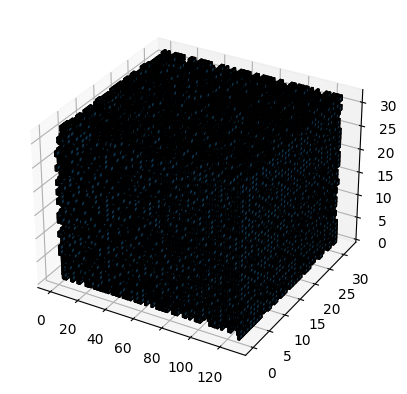

In [99]:
gen=gen.cpu()
get_volume_views(d3_fake.cpu(), downsample=True, scale_factor=0.25)

In [137]:
gen=gen.cuda()

In [22]:
gen_losses=[]
disc_losses=[]

In [ ]:
iteration=0
for epoch in range(10):
    for batch in tqdm(dataloader):
        iteration+=1
        d2=batch[0]
        d3=batch[1]
        d2=d2.cuda()
        d3=d3.cuda()
        d3_fake=gen(d2)
#         print(d2.shape)
#         print(d3.shape)

        D_real=disc(d2,d3)
        
        D_real_loss=0
        
        D_fake=disc(d2,d3_fake.detach())
        D_fake_loss=BCE_Loss(D_fake,torch.zeros_like(D_fake))
        D_loss=(D_real_loss+D_fake_loss)/2
        disc.zero_grad()
        D_loss.backward()
        disc_opt.step()
        
        D_fake=disc(d2,d3_fake)
        G_fake_loss=BCE_Loss(D_fake,torch.ones_like(D_fake))
        L1=L1_Loss(d3_fake,d3)*LAMBDA
        G_loss=G_fake_loss+L1
        
        gen_opt.zero_grad()
        G_loss.backward()
        gen_opt.step() 
        #================================================================
        #================================================================
#         
        #================================================================
        #================================================================
        if iteration % 150 == 0 and iteration > 0:
            print(f"Step {iteration}: Generator loss: {G_loss}, discriminator loss: {D_loss}")
            gen_losses.append(G_loss)
            disc_losses.append(D_loss)

#             generate_images(gen,s['B'].cuda(),s['A'].cuda())
        
        
        

  0%|          | 0/10069 [00:00<?, ?it/s]

Step 150: Generator loss: 6.631526947021484, discriminator loss: 0.04188716411590576
Step 300: Generator loss: 45.66777038574219, discriminator loss: 0.01590430736541748
Step 450: Generator loss: 8.471471786499023, discriminator loss: 0.007894039154052734
Step 600: Generator loss: 6.455746650695801, discriminator loss: 0.004596710205078125
Step 750: Generator loss: 68.9645767211914, discriminator loss: 0.002964019775390625


In [24]:
!TORCH_USE_CUDA_DSA=1

## =================

In [358]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Layer Definition
        vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(vgg16_bn.features.children()))[:27]
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=3)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, kernel_size=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ELU()
        )

        # Don't update params in VGG16
        for param in vgg16_bn.parameters():
            param.requires_grad = False

    def forward(self, rendering_images):
        rendering_images = rendering_images.permute(1, 0, 2, 3, 4).contiguous()
        rendering_images = torch.split(rendering_images, 1, dim=0)
        image_features = []

        for img in rendering_images:
            features = self.vgg(img.squeeze(dim=0))
            features = self.layer1(features)
            features = self.layer2(features)
            features = self.layer3(features)
            image_features.append(features)

        image_features = torch.stack(image_features).permute(1, 0, 2, 3, 4).contiguous()
        return image_features

In [359]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(2048, 512, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(512),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(512, 128, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(128),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 32, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU()
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(32, 8, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(8),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(8, 1, kernel_size=1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, image_features):
        image_features = image_features.permute(1, 0, 2, 3, 4).contiguous()
        image_features = torch.split(image_features, 1, dim=0)
        gen_volumes = []
        raw_features = []

        for features in image_features:
            gen_volume = features.view(-1, 2048, 2, 2, 2)
            gen_volume = self.layer1(gen_volume)
            gen_volume = self.layer2(gen_volume)
            gen_volume = self.layer3(gen_volume)
            gen_volume = self.layer4(gen_volume)
            raw_feature = gen_volume
            gen_volume = self.layer5(gen_volume)
            raw_feature = torch.cat((raw_feature, gen_volume), dim=1)

            gen_volumes.append(torch.squeeze(gen_volume, dim=1))
            raw_features.append(raw_feature)

        gen_volumes = torch.stack(gen_volumes).permute(1, 0, 2, 3, 4).contiguous()
        raw_features = torch.stack(raw_features).permute(1, 0, 2, 3, 4, 5).contiguous()
        return raw_features, gen_volumes

In [360]:
def init_weights(m):
    if type(m) == torch.nn.Conv2d or type(m) == torch.nn.Conv3d or type(m) == torch.nn.ConvTranspose3d:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.BatchNorm2d or type(m) == torch.nn.BatchNorm3d:
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, 0, 0.01)
        torch.nn.init.constant_(m.bias, 0)

In [26]:
class UNet3DGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet3DGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # [BATCH, 64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [BATCH, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # [BATCH, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # [BATCH, 512, 8, 8]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Adjust decoder with more layers to upscale depth from 16 to 128
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=1),  # [BATCH, 256, 32, 64, 64]
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=1),  # [BATCH, 128, 64, 128, 128]
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=1),  # [BATCH, 64, 128, 128, 128]
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(64, output_channels, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=1),  # [BATCH, 1, 128, 128, 128]
            nn.Tanh()
        )

    def forward(self, x):
        # Apply the 2D encoder
        enc_output = self.encoder(x)
        # Reshape the output from 2D to 3D
        enc_output = enc_output.view(enc_output.size(0), enc_output.size(1), 1, enc_output.size(2), enc_output.size(3))
        # Apply the 3D decoder
        dec_output = self.decoder(enc_output)
        return dec_output


In [27]:
gen=UNet3DGenerator()

In [29]:
gen(batch[0]).shape

torch.Size([1, 1, 16, 128, 128])

In [397]:
class Discriminator3D(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator3D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # [BATCH, 64, 64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # [BATCH, 128, 32, 32, 32]
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # [BATCH, 256, 16, 16, 16]
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(256, 512, kernel_size=4, stride=2, padding=1),  # [BATCH, 512, 8, 8, 8]
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(512, 1, kernel_size=4, stride=2, padding=1),  # [BATCH, 1, 4, 4, 4]
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [404]:
generator = UNet3DGenerator(input_channels=3, output_channels=1)
discriminator = Discriminator3D(input_channels=1)

In [405]:
input_2d = torch.randn((4, 3, 128, 128))  # Example input with BATCH_SIZE=4
output_3d = generator(input_2d)

In [437]:
from tensorflow.keras.layers import ConvLSTM2D, Bidirectional, BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D, Activation, Input
from tensorflow.keras.layers import MaxPooling3D, UpSampling3D, Conv3DTranspose, concatenate
from tensorflow.keras.models import Model

def UNet_Model(input_shape):
    in_layer = Input(input_shape)
    bn = BatchNormalization()(in_layer)
    cn1 = Conv3D(8, 
               kernel_size = (1, 5, 5), 
               padding = 'same',
               activation = 'relu')(bn)
    cn2 = Conv3D(8, 
               kernel_size = (3, 3, 3),
               padding = 'same',
               activation = 'linear')(cn1)
    bn2 = Activation('relu')(BatchNormalization()(cn2))

    dn1 = MaxPooling3D((2, 2, 2))(bn2)
    cn3 = Conv3D(16, 
               kernel_size = (3, 3, 3),
               padding = 'same',
               activation = 'linear')(dn1)
    bn3 = Activation('relu')(BatchNormalization()(cn3))

    dn2 = MaxPooling3D((1, 2, 2))(bn3)
    cn4 = Conv3D(32, 
               kernel_size = (3, 3, 3),
               padding = 'same',
               activation = 'linear')(dn2)
    bn4 = Activation('relu')(BatchNormalization()(cn4))

    up1 = Conv3DTranspose(16, 
                        kernel_size = (3, 3, 3),
                        strides = (1, 2, 2),
                        padding = 'same')(bn4)

    cat1 = concatenate([up1, bn3])

    up2 = Conv3DTranspose(8, 
                        kernel_size = (3, 3, 3),
                        strides = (2, 2, 2),
                        padding = 'same')(cat1)

    pre_out = concatenate([up2, bn2])

    pre_out = Conv3D(1, 
               kernel_size = (1, 1, 1), 
               padding = 'same',
               activation = 'sigmoid')(pre_out)

    pre_out = Cropping3D((1, 2, 2))(pre_out) # avoid skewing boundaries
    out = ZeroPadding3D((1, 2, 2))(pre_out)
    return Model(inputs = [in_layer], outputs = [out])


In [438]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose, UpSampling3D, Input
from tensorflow.keras.models import Model

def EncoderDecoder_Model(input_shape):
    in_layer = Input(input_shape)
    t = Conv3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(in_layer)
    t = Conv3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(t)
    t = MaxPooling3D((2, 2, 2))(t)
    t = Conv3D(128, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(t)
    t = Conv3D(128, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu')(t)
    t = MaxPooling3D((2, 2, 2))(t)

    t = Conv3DTranspose(128, kernel_size=(3, 3, 3), padding='same', activation='relu')(t)
    t = Conv3DTranspose(128, kernel_size=(3, 3, 3), padding='same', activation='relu')(t)
    t = UpSampling3D((2, 2, 2))(t)
    t = Conv3DTranspose(64, kernel_size=(3, 3, 3), padding='same', activation='relu')(t)
    t = Conv3DTranspose(64, kernel_size=(3, 3, 3), padding='same', activation='relu')(t)
    t = UpSampling3D((2, 2, 2))(t)

    t = Conv3D(1, kernel_size=(3, 3, 3), padding='same', activation='relu')(t)

    return Model(in_layer, t, name='EncoderDecoder')

In [ ]:
model = UNet_Model(input_shape=128)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt,loss=tf.keras.losses.MeanSquaredError())



In [ ]:
import os
import numpy as np
# from Models import EncoderDecoder, UNet
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
# from Tools import metrics
# from Tools import callbacks
import nibabel as nib
import utils
from pathlib import Path


class Experiment_transformation():
    def __init__(self, preprocessed_dataset_path=None, network_structure='UNet', base_project_dir='.', args={}, mode='train'):
        self.preprocessed_dataset_path = preprocessed_dataset_path
        self.network_structure = network_structure
        self.base_project_dir = base_project_dir
        self.args = args
        self.task = ''
        self.mode = mode

        gpu_devices = tf.config.experimental.list_physical_devices("GPU")
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)

    def prepare(self):
        self.train_dataset, self.val_dataset, self.test_dataset, self.file_names = utils.create_dataset(self.preprocessed_dataset_path, self.args['val_ratio'], self.args['test_ratio'], True, self.args['random_seed'])

        # this is useful for 'generate_output' mode where we wnat to save data
        image_path = os.path.join(self.base_project_dir, 'Data', 'US_Images', '0001_US_Image_a.nii.gz')
        nii_img  = nib.load(image_path)
        self.images_metadata = {'affine':nii_img.affine, 'header':nii_img.header}

        example_us, _ = next(iter(self.test_dataset))
#         self.args['input_shape'] =  example_us.shape #list(example_us.shape) + [1]
#         print('Input Shape:', self.args['input_shape'])
#         print('\nTrain size:', len(self.train_dataset))
#         print('Val size:', len(self.val_dataset))
#         print('Test size:', len(self.test_dataset))
        
        self.task += self.network_structure 
        
        output_dir = os.path.join(self.base_project_dir, 'Output', self.task)
        output_models_dir = os.path.join(output_dir, 'TrainedModels')
        self.args['best_models_dir'] = os.path.join(output_models_dir, 'BestModels')
        self.args['last_models_dir']= os.path.join(output_models_dir, 'LastModels')
        self.args['log_dir'] = os.path.join(output_dir, 'Log')
        self.args['sample_generated_images_dir'] = os.path.join(output_dir, 'SampleGeneratedImages')

        if self.network_structure == 'EncoderDecoder':
            self.model = EncoderDecoder.EncoderDecoder_Model(input_shape=self.args['input_shape'])
        elif self.network_structure == 'UNet':
            self.model = UNet.UNet_Model(input_shape=self.args['input_shape'])

        if os.path.exists(os.path.join(self.args['last_models_dir'], self.task + '.h5')):
            print('[INFO] Loading pretrained model weights from: ' + self.args['last_models_dir'])
            pretrained_model_path = os.path.join(self.args['last_models_dir'], self.task + '.h5')
            self.model.load_weights(pretrained_model_path)
        else:
            print('[INFO] Pretrained weights not found. training will be strated using randomly intialized weights.')

        self.model.summary()
        
        Path(self.args['best_models_dir']).mkdir(parents=True, exist_ok=True)
        Path(self.args['last_models_dir']).mkdir(parents=True, exist_ok=True)
        Path(self.args['sample_generated_images_dir']).mkdir(parents=True, exist_ok=True)

        print("Task: " + self.task)

        
    def train(self):

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        self.args['initial_lr'],
        decay_steps=self.args['decay_steps'],
        decay_rate=self.args['decay_rate'],
        staircase=True
        )

        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.model.compile(
            optimizer=opt,
            loss=  tf.keras.losses.MeanSquaredError()
        )

        save_model_callback = callbacks.SaveModel(
            save_best_model_to=os.path.join(self.args['best_models_dir'], self.task + '.h5'),
            save_last_model_to=os.path.join(self.args['best_models_dir'], self.task + '.h5')
        )

        print('\n\n')  

        self.model.save('InitialModel.h5')

        try:
            self.model.fit_generator(
                generator=self.train_dataset.batch(self.args['batch_size']),
                steps_per_epoch=len(self.train_dataset) // self.args['batch_size'],
                epochs=self.args['max_epochs'],
                callbacks=[save_model_callback, ],
                validation_data=self.val_dataset.batch(len(self.val_dataset)),
                )
        except KeyboardInterrupt :
            pass

    def generate_output(self):
        output_path = os.path.join(self.base_project_dir, 'Output', self.task, 'Results')
        Path(output_path).mkdir(parents=True, exist_ok=True)
        for set_name in ['train', 'val', 'test']:
            for result_dir_name in ['GeneratedImages', 'DifferentialImages', 'ResultedMetrics']:
                result_dir_path = os.path.join(output_path, set_name, result_dir_name)
                Path(result_dir_path).mkdir(parents=True, exist_ok=True)

        print('Loading the best model weights from: ' + self.args['best_models_dir'])
        self.model.load_weights(os.path.join(self.args['best_models_dir'], self.task + '.h5'))

        print('Generating outputs ...')
        for set_name in ['train', 'val', 'test']:
            generated_images_path = os.path.join(output_path, set_name, 'GeneratedImages')
            differential_images_path = os.path.join(output_path, set_name, 'DifferentialImages')
            resulted_metrics_path = os.path.join(output_path, set_name, 'ResultedMetrics')
            
            df_columns_names = ['MAE', 'MAPE', 'RMSE', 'SSI']#, 'PSNR']
            df_metrics = pd.DataFrame(columns=df_columns_names)

            if set_name == 'train':
                dataset = self.train_dataset
            elif set_name == 'val':
                dataset = self.val_dataset
            elif set_name == 'test':
                dataset = self.test_dataset

            for i, (US, gt_MRI) in tqdm(enumerate(dataset)):
                file_name = self.file_names[set_name][i].split(os.sep)[-1].replace('.npz', '.nii.gz')
                US = US.numpy()
                gt_MRI = gt_MRI.numpy()

                pred_MRI = self.model(np.expand_dims(US, axis=0), training=True).numpy()
                pred_MRI = np.squeeze(pred_MRI)
                gt_MRI = np.squeeze(gt_MRI)

                pred_MRI_path = os.path.join(generated_images_path, file_name)
                pred_nii_img = nib.Nifti1Image(pred_MRI, self.images_metadata['affine'], self.images_metadata['header'])
                nib.save(pred_nii_img, pred_MRI_path)

                diff_MRI = gt_MRI - pred_MRI
                diff_MRI_path = os.path.join(differential_images_path, file_name)
                diff_nii_img = nib.Nifti1Image(diff_MRI, self.images_metadata['affine'], self.images_metadata['header'])
                nib.save(diff_nii_img, diff_MRI_path)

                mae = metrics.Mean_absolute_error(gt_MRI, pred_MRI)
                mape = metrics.Mean_absolute_percentage_error(gt_MRI, pred_MRI)
                rmse = metrics.Root_mean_squared_error(gt_MRI, pred_MRI)
                ssi = metrics.Structural_similarity(gt_MRI, pred_MRI)
                # psnr = metrics.Peak_signal_noise_ratio(gt_MRI, pred_MRI)
                # psnr = 0

                df_metrics.loc[file_name] = [mae, mape, rmse, ssi]#, psnr]
            
            df_metrics_path = os.path.join(resulted_metrics_path, 'CalculatedMetrics.csv')
            df_metrics.to_csv(df_metrics_path)